# Resume Relevence Model Creator

In [1]:
# The links to the dataset can be found here:
# https://www.kaggle.com/datasets/jillanisofttech/updated-resume-dataset
# https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset
# https://www.kaggle.com/datasets/arshkon/linkedin-job-postings

# I combined the resume-dataset and updated-resume-dataset into resumes.csv.

In [2]:
%load_ext memory_profiler
%memit
import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow as tf
import logging
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import ssl
import nltk
import hashlib
import json
import time
from openai import OpenAI

client = OpenAI(api_key="sk-proj-sScFMZr4GK3XaQ5mcYFYT3BlbkFJ1orIjm1gKSNT0q30KBMZ")

peak memory: 63.70 MiB, increment: 0.39 MiB


In [3]:
%%memit
postings = pd.read_csv("100K_data/400_postings.csv")
resumes = pd.read_csv("100K_data/250_resumes.csv")
display(postings)
display(resumes)

,description
0,Job descriptionA leading real estate firm in N...
1,"At Aspen Therapy and Wellness , we are committ..."
2,The National Exemplar is accepting application...
3,Senior Associate Attorney - Elder Law / Trusts...
4,Looking for HVAC service tech with experience ...
...,...
395,Fundraising Events CoordinatorReports to: Deve...
396,Job Title: Bilingual Legal Assistant/Paralegal...
397,Exciting Opportunity Alert! Discover your next...
398,Company Description\n SEOGidi is a Search Engi...


,Resume,Category
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,HR DIRECTOR Summary Over 2...,HR
3,HR SPECIALIST Summary Dedica...,HR
4,HR MANAGER Skill Highlights ...,HR
...,...,...
245,"Sure, I'd be happy to help you create a profes...",NaN
246,"Sure, I'd be happy to help you create a profes...",NaN
247,"Sure, I'd be happy to help you create a profes...",NaN
248,"Sure, I'd be happy to help you create a profes...",NaN


peak memory: 620.91 MiB, increment: 12.70 MiB


## Create Labels by reading Cache from file

In [4]:
%%memit
if os.path.exists('100K_cache.json'):
	with open('100K_cache.json', 'r') as cache_file:
		cache = json.load(cache_file)
else:
	print("ERROR: Could not find cache. Aborting")
	sys.exit(1)


labels = []
for job_description in postings['description']:
	for resume_text in resumes['Resume']:
		key = hashlib.md5(f"{resume_text}{job_description}".encode()).hexdigest()
		relevance = cache.get(key)
		if relevance == None:
			print(f"ERROR: COULD NOT FIND LABEL FOR KEY {key}. THIS SHOULD BE ADDRESSED. DEFAULTING TO 0")
			relevance = 0
		labels.append(relevance)

print(labels)

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 

## Preprocess then Vectorize text

In [5]:
%%memit

nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text_series):
    logging.info("Preprocessing text...")
    text_series = text_series.fillna("")  # Replace NaN with empty strings
    text_series = text_series.apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    text_series = text_series.apply(lambda x: ' '.join(
        lemmatizer.lemmatize(word) for word in x.split() if word not in stop_words
    ))
    return text_series

resumes['Resume'] = preprocess_text(resumes['Resume'])
postings['description'] = preprocess_text(postings['description'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/armandrismir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/armandrismir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


peak memory: 697.75 MiB, increment: 68.67 MiB


In [6]:
%%memit
universal_sentence_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def vectorize_text(text_series):
    logging.info("Vectorizing text...")
    embeddings = universal_sentence_encoder(text_series.tolist()).numpy()
    return embeddings

vectorized_resumes = vectorize_text(resumes['Resume'])
vectorized_postings = vectorize_text(postings['description'])

peak memory: 1373.73 MiB, increment: 675.98 MiB


## Create Resume, Posting vector pairs

In [7]:
%%memit
resume_posting_pairs = [(vectorized_resumes[i], vectorized_postings[j])
                for i in range(len(resumes)) for j in range(len(postings))]
# Ensure vector pairs are numpy arrays
resume_posting_pairs = [(np.array(left), np.array(right)) for left, right in resume_posting_pairs]

peak memory: 1406.78 MiB, increment: 0.28 MiB


## Train a ML Model using Vector pairs and Labels
(needs nvidia driver)

In [8]:
device = torch.device('cpu')
train_pairs, test_pairs, train_labels, test_labels = train_test_split(resume_posting_pairs, labels, test_size=0.05, random_state=42)
logging.info("Data split into training and testing sets.")
print("Training and testing data prepared.")

train_left = np.array([x[0] for x in train_pairs])
train_right = np.array([x[1] for x in train_pairs])
test_left = np.array([x[0] for x in test_pairs])
test_right = np.array([x[1] for x in test_pairs])

train_data = (torch.tensor(train_left, dtype=torch.float32), torch.tensor(train_right, dtype=torch.float32))
test_data = (torch.tensor(test_left, dtype=torch.float32), torch.tensor(test_right, dtype=torch.float32))

train_labels = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1)
test_labels = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1)

print("Train Data Shape:", (train_left.shape, train_right.shape))
print("Train Data Type:", (type(train_left), type(train_right)))
print("Train Labels Shape:", len(train_labels))
print("Train Labels Type:", type(train_labels))
print("Test Data Shape:", (test_left.shape, test_right.shape))
print("Test Data Type:", (type(test_left), type(test_right)))
print("Test Labels Shape:", len(test_labels))
print("Test Labels Type:", type(test_labels))

class SiameseNetwork(nn.Module):
    def __init__(self, input_size):
        super(SiameseNetwork, self).__init__()
        self.shared_network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.output_layer = nn.Linear(64, 1)

    def forward_one_side(self, x):
        return self.shared_network(x)

    def forward(self, input1, input2):
        output1 = self.forward_one_side(input1)
        output2 = self.forward_one_side(input2)
        distance = torch.abs(output1 - output2)
        output = torch.sigmoid(self.output_layer(distance))
        return output

input_size = train_left.shape[1]

model = SiameseNetwork(input_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

early_stopping_patience = 10
num_epochs = 50
batch_size = 8

train_dataset = torch.utils.data.TensorDataset(train_data[0], train_data[1], train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(test_data[0], test_data[1], test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

best_val_loss = float('inf')
patience_counter = 0

logging.info("Starting model training...")
print("Starting model training...")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_idx, (left, right, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(left.to(device), right.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (left, right, labels) in enumerate(test_loader):
            outputs = model(left.to(device), right.to(device))
            loss = criterion(outputs, labels.to(device))
            val_loss += loss.item()

    val_loss /= len(test_loader)

    logging.info(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), '100K_siamese_network.pth')
        logging.info("Model saved.")
        print("Model saved.")
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            logging.info("Early stopping triggered.")
            print("Early stopping triggered.")
            break

# logging.info("Model training completed.")
# print("Model training completed.")

model.load_state_dict(torch.load('100K_siamese_network.pth', map_location=device))
logging.info("Best model loaded.")
print("Best model loaded.")

Training and testing data prepared.
Train Data Shape: ((95000, 512), (95000, 512))
Train Data Type: (<class 'numpy.ndarray'>, <class 'numpy.ndarray'>)
Train Labels Shape: 95000
Train Labels Type: <class 'torch.Tensor'>
Test Data Shape: ((5000, 512), (5000, 512))
Test Data Type: (<class 'numpy.ndarray'>, <class 'numpy.ndarray'>)
Test Labels Shape: 5000
Test Labels Type: <class 'torch.Tensor'>
Best model loaded.


/var/folders/gl/d35y1q0n1tv41dfx9xttz8fw0000gn/T/ipykernel_11398/3108221529.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('100K_siam

# Measuring the performance of the model:

In [9]:
device = torch.device('cpu')
model = SiameseNetwork(512)
model.load_state_dict(torch.load('100K_siamese_network.pth', map_location=device))
model.eval()
predictions = []
labels = []
loss = []

for vec_r, vec_p, label in zip(test_data[0], test_data[1], test_labels):
    prediction = model(vec_r.unsqueeze(0), vec_p.unsqueeze(0)).item()
    if prediction == 1:
        print(f"{prediction:.2f},{label.item()}")
    predictions.append(prediction)
    labels.append(label.item())
    loss.append(abs(prediction - label.item()))

results = pd.DataFrame({
    'Prediction': predictions,
    'Labels': labels,
    'Loss': loss
})

results

/var/folders/gl/d35y1q0n1tv41dfx9xttz8fw0000gn/T/ipykernel_11398/1121169194.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('100K_siames

,Prediction,Labels,Loss
0,0.083014,0.0,0.083014
1,0.086396,0.0,0.086396
2,0.076416,0.0,0.076416
3,0.058313,0.0,0.058313
4,0.100203,0.0,0.100203
...,...,...,...
4995,0.086244,0.0,0.086244
4996,0.068214,0.0,0.068214
4997,0.060133,0.0,0.060133
4998,0.073493,0.0,0.073493


We are treating this as a regression problem. <br />
Each pair gets a rating between unqualified (0) to qualified (1). <br />
We were off on average by about **15%**. <br />

In [10]:
results.describe()

,Prediction,Labels,Loss
count,5000.000000,5000.000000,5000.000000
mean,0.087118,0.083200,0.150072
std,0.045641,0.276212,0.223863
min,0.000108,0.000000,0.000108
25%,0.056611,0.000000,0.057367
50%,0.079868,0.000000,0.081486
75%,0.107199,0.000000,0.112442
max,0.353771,1.000000,0.999708


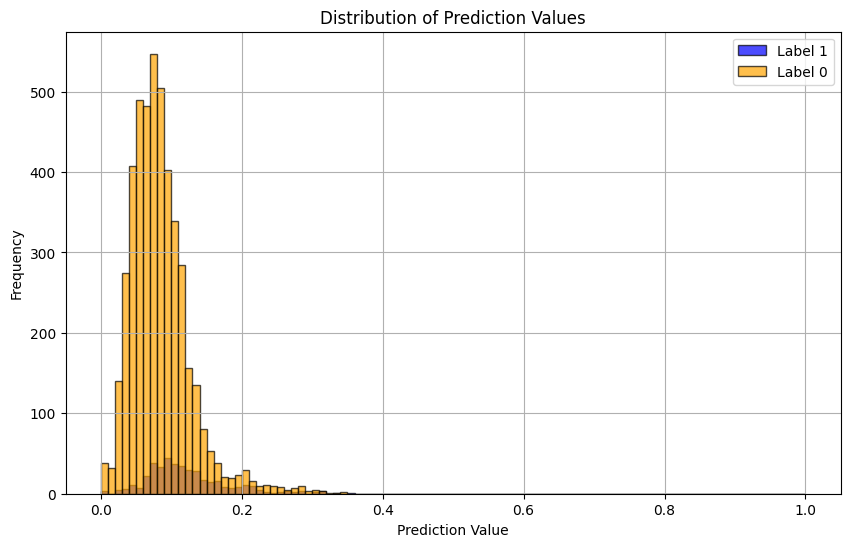

In [16]:
predictions_label_1 = results[results['Labels'] == 1]['Prediction']
predictions_label_0 = results[results['Labels'] == 0]['Prediction']

# Plot the histograms
plt.figure(figsize=(10, 6))  # Optional: Set the size of the plot

# Plot for label 1
plt.hist(predictions_label_1, bins=100, edgecolor='black', alpha=0.7, range=(0, 1), color='blue', label='Label 1')

# Plot for label 0
plt.hist(predictions_label_0, bins=100, edgecolor='black', alpha=0.7, range=(0, 1), color='orange', label='Label 0')

plt.title('Distribution of Prediction Values')
plt.xlabel('Prediction Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()  # Add legend to distinguish between the two labels
plt.show()

#### Next steps:
 - Treat as classifier

In [14]:
classes = []
for p in predictions:
	if p < 0.2:
		classes.append(0)
	else:
		classes.append(1)
class_results =  pd.DataFrame({
    'Prediction': predictions,
    'Labels': labels,
    'Class': classes
})

class_results

,Prediction,Labels,Class
0,0.083014,0.0,0
1,0.086396,0.0,0
2,0.076416,0.0,0
3,0.058313,0.0,0
4,0.100203,0.0,0
...,...,...,...
4995,0.086244,0.0,0
4996,0.068214,0.0,0
4997,0.060133,0.0,0
4998,0.073493,0.0,0


In [15]:
from sklearn.metrics import precision_score, recall_score

correct_predictions = (class_results['Labels'] == class_results['Class']).sum()
total_predictions = len(class_results)
accuracy = correct_predictions / total_predictions * 100
print(f'Percentage of correct classes: {accuracy:.2f}%')

# Calculate recall and precision
recall = recall_score(class_results['Labels'], class_results['Class'])
precision = precision_score(class_results['Labels'], class_results['Class'])
print(f'Recall: {recall:.10f}')
print(f'Precision: {precision:.10f}')

Percentage of correct classes: 90.24%
Recall: 0.1105769231
Precision: 0.2804878049
